## Tarea Renta Variable - MIAX
#### Juan José Daza Linares - 07/12/2025

### Introducción

Este Notebook proporciona una resolución a la *Tarea de Renta Variable*. A lo largo de este archivo, se irán resolviendo las diferentes cuestiones planteadas, con la ayuda de los métodos auxiliares desarrollados en los archivos *src/reader.py* y *src/analyzer.py*.

In [1]:
import reader
import analyzer
import pandas as pd
import matplotlib.pyplot as plt

### Money Table

*A summary table showing the Total Realized Profit for all processed ISINs at each latency level*

Obtenemos una lista con todos los ISIN

In [2]:
isins = reader.get_all_isins()
print(isins)

['ES0140609019', 'ES0178165017', 'ES0105634002', 'ES0105606190', 'ES0173093024', 'DE000SX0AMY5', 'GB00BDCPN049', 'BRBBDCACNPR8', 'ES0171743901', 'DE000FD1Q5F6', 'DE000FD1Q4U8', 'ES0105589008', 'DE000FD1Q4A0', 'DE000SX50XC2', 'ES0105848008', 'ES0126501131', 'ES0136463017', 'ES0172708234', 'ES0167050915', 'ES0105287009', 'ES0105857009', 'ES0114820113', 'NLBNPES1ZMK7', 'ES0121975009', 'ES0130960018', 'ES0175589029', 'NLBNPES1Q3T8', 'DE000FA5G8E7', 'ES0105621009', 'ES0105336038', 'DE000SQ6DV56', 'DE000FD1Q344', 'PEP648014202', 'FR0010251744', 'ES0118594417', 'ES0116920333', 'ES0177542018', 'ES0105102000', 'DE000FD1QYE5', 'ES0105884011', 'LU1598757687', 'DE000FA5HGL0', 'ES0105618005', 'ES0105709002', 'ES0169501022', 'NL0000235190', 'ES0105548004', 'ES0157261019', 'ES0109260531', 'AU000000BKY0', 'ES0105089009', 'ES0112501012', 'ES0105375002', 'DE000SX0AZM2', 'ES0105509006', 'ES06837469D8', 'DE000FA5HCF1', 'DE000FD1Q0E0', 'DE000FD1QS80', 'ARP125991090', 'DE000SQ6DV64', 'DE000SW92XJ1', 'DE000F

Para cada isin vamos a calcular sus arbitrajes y, posteriormente, haremos una tabla con ISIN - Beneficio - Latencia

In [3]:
latencies = [0, 100, 500, 1000, 2000, 3000, 4000, 5000, 10000, 15000, 20000, 30000, 50000, 100000]
beneficios_por_isin = pd.DataFrame(columns=latencies, index=isins)
for isin in isins:
    isin_df = reader.load_for_isin(isin)
    if isin_df is not None:
        for latency in latencies:
            arbitrages = analyzer.find_arbitrage(isin_df, latency)
            beneficios_por_isin.loc[isin, latency] = arbitrages['Profit'].sum()
    else:
        print(f"WARN: No se han podido cargar datos para el ISIN {isin}")

WARN: No se han podido cargar datos para el ISIN ES0155887039
WARN: No se han podido cargar datos para el ISIN ES0110241009
WARN: No se han podido cargar datos para el ISIN ES0155734033
WARN: No se han podido cargar datos para el ISIN ES0137927135
WARN: No se han podido cargar datos para el ISIN ES0175496035


In [4]:
beneficios_totales = pd.DataFrame([beneficios_por_isin.sum()])
beneficios_totales.head()

,0,100,500,1000,2000,3000,4000,5000,10000,15000,20000,30000,50000,100000
0,1108.343,14.047,0.137,9.3,1.67,0,1.555,7.649,0,0.968,0,0.38,0,0


### The Decay Chart

*A line chart visualizing how Total Profit (Y-axis) decays as Latency (X-axis) increases*

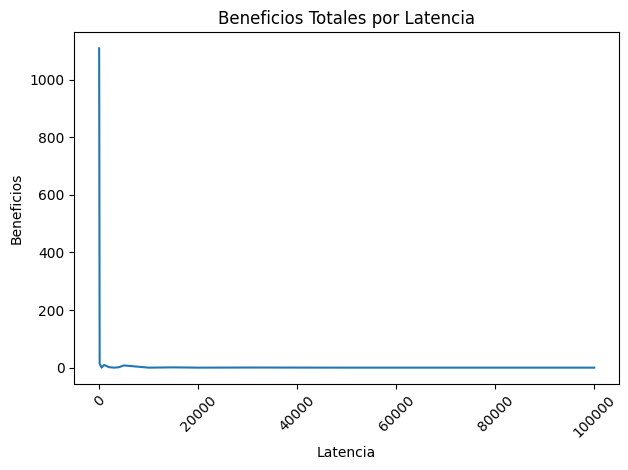

In [5]:
plt.plot(beneficios_totales.columns, beneficios_totales.iloc[0])
plt.xlabel("Latencia")
plt.ylabel("Beneficios")
plt.title("Beneficios Totales por Latencia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top Opportunities

*A list of the Top 5 most profitable ISINs (at 0 latency). Sanity check these results—do they look real?*

In [6]:
beneficios_por_isin.sort_values(by=0, ascending=False)[0].head(5)

ES0177542018    588.744
ES0113211835    142.795
ES0109067019     104.76
ES0113900J37      84.22
ES0171996095     47.885
Name: 0, dtype: object

Un arbitraje para el ISIN ES0177542018 da un beneficio demasiado elevado. Si com